### Imports

In [ ]:
import os
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
import tensorflow as tf
from tensorflow.keras.layers import Lambda
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.layers import LeakyReLU, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

### Access to dataset

In [ ]:
drive.mount(r'/content/drive/',force_remount=True) 
data_dir = os.getcwd() + '/drive/My Drive/Colab Notebooks/DeepLearning/FinalProject/data/'
data_dir

Mounted at /content/drive/


'/content/drive/My Drive/Colab Notebooks/DeepLearning/FinalProject/data/'

In [ ]:
os.listdir(data_dir)

['data_to_test.csv',
 'data_to_val.csv',
 'data_to_tra.csv',
 'category_and_image_downscaled_data.zip']

### Loading dataset

In [ ]:
df = pd.read_csv(data_dir + 'category_and_image_downscaled_data.zip', compression="zip")
df.shape

(142480, 2327)

### Focus on a single class

In [ ]:
df = df.loc[df["categorytype"] == "headwear"]

### Create Dataframes - Train, Val, Test (60%, 20%, 20%)

In [ ]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_test = train_test_split(df_train, test_size=0.25, random_state=42)
df_train.shape, df_valid.shape, df_test.shape

((1801, 2327), (601, 2327), (601, 2327))

In [ ]:
df_train.head()

,Unnamed: 0,Unnamed: 0.1,set_id,set_views,set_likes,date,set_name,desc,number_of_items,days_since_post,items_likes,set_price,index,item_name,item_price,item_likes,image,categoryid,category_name,categorytype_id,categorytype,category,num items,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,...,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
112228,112228,112228,216604219,1029,428,7 days,Win $20 Cash from Rosegal!,A menswear look from February 2017 by mahafrom...,7,7.0,2746,775.54,4,trendy tea colored brow frame sunglasses,5.54,6,/content/drive/My Drive/data/images_clean/2166...,304,Men's Sunglasses,6,headwear,Men's Sunglasses,178,255.0,255.0,255.0,255.0,254.0,255.0,252.0,252.0,254.0,254.0,255.0,254.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,254.0,254.0,254.0,254.0,254.0,254.0,255.0,254.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,254.0,255.0,255.0,255.0,254.0,254.0,254.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
115040,115040,115040,210870664,1987,540,Three months,DRESS,A fashion look from November 2016 by masayuki4...,5,90.0,3731,1937.00,5,accessorize wool beret,12.00,2058,/content/drive/My Drive/data/images_clean/2108...,55,Hats,6,headwear,Hats,2178,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,142.0,161.0,170.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
266,266,266,132440126,258,11,Two years,Buying a Puppy with Calum and Ash,A fashion look from August 2014 featuring brow...,8,730.0,35400,783.25,8,dolce gabbana dolce gabbana hat,135.00,785,/content/drive/My Drive/data/images_clean/1324...,55,Hats,6,headwear,Hats,2178,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,254.0,254.0,254.0,254.0,254.0,252.0,252.0,254.0,254.0,254.0,251.0,253.0,253.0,253.0,253.0,254.0,254.0,254.0,255.0,255.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
21475,21475,21475,201686624,3241,885,7 months,Over And Over,A fashion look from June 2016 by marina-volari...,8,210.0,41759,797.26,5,yellow baseball cap,5.26,197,/content/drive/My Drive/data/images_clean/2016...,55,Hats,6,headwear,Hats,2178,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,254.0,254.0,254.0,254.0,254.0,254.0,254.0,254.0,254.0,254.0,253.0,253.0,253.0,253.0,253.0,253.0,253.0,253.0,254.0,254.0,254.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
71808,71808,71808,215939119,168,29,19 days,Brunch with the Boss Babes,Dress: https://goo.gl/Mo7POi \nCardigan: https...,5,19.0,5718,827.00,5,rag bone women's white panama hat,230.00,2266,/content/drive/My Drive/data/images_clean/2159...,55,Hats,6,headwear,Hats,2178,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,...,254.0,255.0,255.0,255.0,253.0,255.0,253.0,254.0,255.0,255.0,254.0,253.0,254.0,253.0,254.0,253.0,253.0,254.0,253.0,252.0,255.0,255.0,254.0,255.0,255.0,254.0,254.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


In [ ]:
train_x = df_train.iloc[:,23:].values.reshape(df_train.shape[0], 48,48,1) #/ 255
valid_x = df_valid.iloc[:,23:].values.reshape(df_valid.shape[0], 48,48,1) #/ 255
test_x = df_test.iloc[:,23:].values.reshape(df_test.shape[0], 48,48,1) #/ 255
num_classes = len(df_train.categorytype_id.unique())
train_y = df_train["categorytype_id"].values
valid_y = df_valid["categorytype_id"].values
test_y = df_test["categorytype_id"].values

### Constants

In [ ]:
IMG_SHAPE = (48, 48, 1)
BATCH_SIZE = 64
EPOCHS = 20

### Create Pairs

In [ ]:
def make_pairs(images, labels):
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive or negative
    pair_images = []
    pair_labels = []
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    num_classes = len(np.unique(labels))
    images_per_label_list = [np.where(labels == i)[0] for i in range(0, num_classes)]
    num_images = images.shape[0]
    # loop over all images
    for img_ind_first in range(len(images)):
        # grab the current image and label belonging to the current
        # iteration
        current_img = images[img_ind_first]

        # plt.figure()
        # plt.imshow(current_img.reshape(48,48))

        # augmentation
        datagens = [ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2), # random shifts
                    ImageDataGenerator(rotation_range=60), # random rotation
                    ImageDataGenerator(horizontal_flip=True), # horizontal flip
                    ImageDataGenerator(zoom_range=[0.5,1.0])] # random zoom
        augmented_images = []
        for datagen in datagens:
            it = datagen.flow(np.expand_dims(current_img, 0), batch_size=1)
            batch = it.next()
            augmented_image = batch[0].astype('uint8')
            augmented_images.append(augmented_image)

        # add positive images
        for pos_img in augmented_images:
            pair_images.append([current_img, pos_img])
            pair_labels.append([1])

        neg_img = images[np.random.choice(num_images)]
        pair_images.append([current_img, neg_img])
        pair_labels.append([0])

    # return a 2-tuple of our image pairs and labels
    return (np.array(pair_images), np.array(pair_labels))

### Euclidean Distnace

In [ ]:
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (embed_1, embed_2) = vectors
    # compute the sum of squared distances between the vectors
    sum_squared = K.sum(K.square(embed_1 - embed_2), axis=1, keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))


### Create network for Embedding

In [ ]:
def get_embeding_vector(input_shape, embedding_dim=48):
    # specify the inputs for the feature extractor network
    inputs = Input(input_shape)
    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, kernel_size = (3, 3), padding="same", activation=LeakyReLU())(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(128, kernel_size = (3, 3), padding="same", activation=LeakyReLU())(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # third set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(256, kernel_size = (3, 3), padding="same", activation=LeakyReLU())(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # fourth set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(512, kernel_size = (3, 3), padding="same", activation=LeakyReLU())(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # fifth set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(1024, kernel_size = (3, 3), padding="same", activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    # prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embedding_dim)(pooledOutput)

    # x = Flatten()(x)
    # x = Dense(1000, activation=LeakyReLU())(x)
    # x = Dropout(0.25)(x)
    # x = Dense(500, activation=LeakyReLU())(x)
    # outputs = Dense(embedding_dim)(x)

    # build the model
    model = Model(inputs, outputs)
    # return the model to the calling function
    return model

### Contrastive Loss

In [ ]:
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squared_preds = K.square(preds)
    squared_margin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squared_preds + (1 - y) * squared_margin)
    # return the computed contrastive loss to the calling function
    return loss

### Plotting Loss Function

In [ ]:
def plot_training(H):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")


### Create Dataset

In [ ]:
# # load dataset and scale the pixel values to the range of [0, 1]
# prepare the positive and negative pairs
(pair_train, label_train) = make_pairs(train_x, train_y)
(pair_valid, label_valid) = make_pairs(valid_x, valid_y)
(pair_test, label_test) = make_pairs(test_x, test_y)

### Create Siamese Network

In [ ]:
img_1 = Input(shape=IMG_SHAPE)
img_2 = Input(shape=IMG_SHAPE)
embeding_extractor = get_embeding_vector(IMG_SHAPE)
embed_1 = embeding_extractor(img_1)
embed_2 = embeding_extractor(img_2)

# construct the siamese network
distance = Lambda(euclidean_distance)([embed_1, embed_2])
model = Model(inputs=[img_1, img_2], outputs=distance)

### Train model

In [ ]:
# compile the model
model.compile(loss=contrastive_loss, optimizer="adam")

# train the model
print("[INFO] training model...")
history = model.fit(
    [pair_train[:, 0], pair_train[:, 1]], label_train[:],
    validation_data=([pair_valid[:, 0], pair_valid[:, 1]], label_valid[:]),
    batch_size=BATCH_SIZE,
    epochs=20)

[INFO] training model...
Epoch 1/20
141/141 [==============================] - 6s 33ms/step - loss: 0.0870 - val_loss: 0.0361
Epoch 2/20
141/141 [==============================] - 4s 31ms/step - loss: 0.0691 - val_loss: 0.0410
Epoch 3/20
141/141 [==============================] - 4s 31ms/step - loss: 0.0560 - val_loss: 0.1054
Epoch 4/20
141/141 [==============================] - 4s 31ms/step - loss: 0.0650 - val_loss: 0.0375
Epoch 5/20
141/141 [==============================] - 4s 31ms/step - loss: 0.0626 - val_loss: 0.0421
Epoch 6/20
141/141 [==============================] - 4s 31ms/step - loss: 0.0999 - val_loss: 0.0346
Epoch 7/20
141/141 [==============================] - 4s 31ms/step - loss: 0.0724 - val_loss: 0.0314
Epoch 8/20
141/141 [==============================] - 4s 31ms/step - loss: 0.0479 - val_loss: 0.0348
Epoch 9/20
141/141 [==============================] - 4s 31ms/step - loss: 0.0651 - val_loss: 0.0840
Epoch 10/20
141/141 [==============================] - 4s 31ms/ste

### Plot Loss

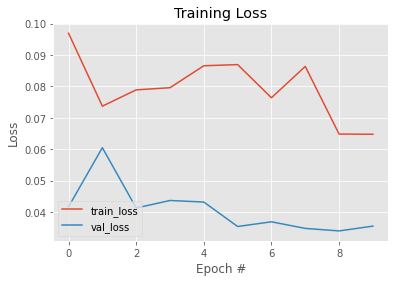

In [ ]:
plot_training(history)

### Test the model

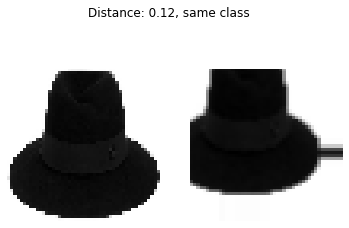

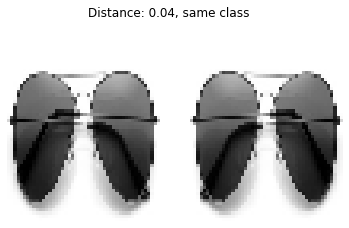

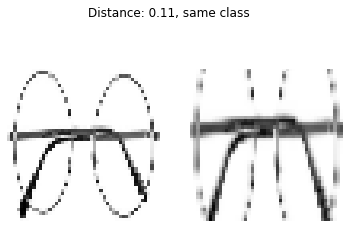

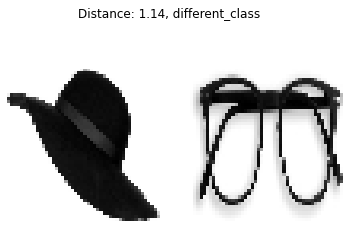

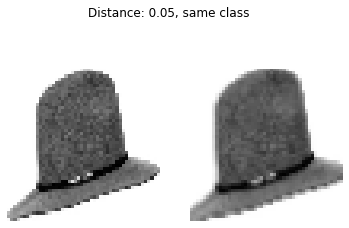

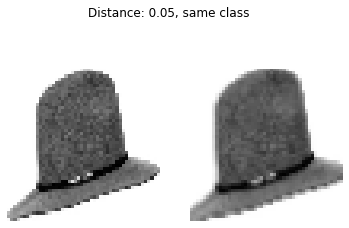

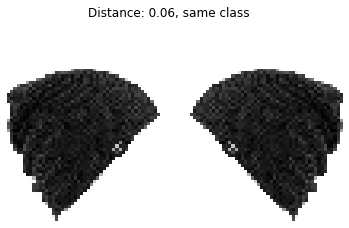

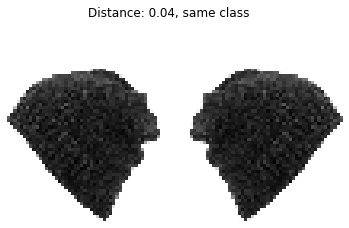

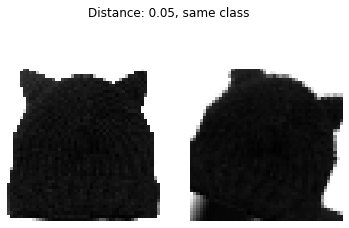

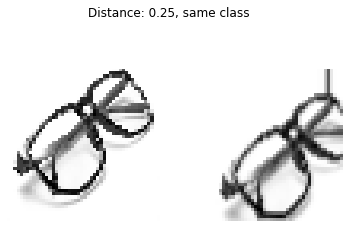

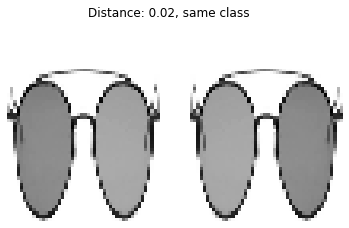

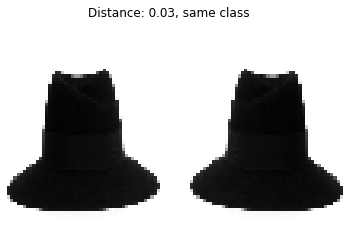

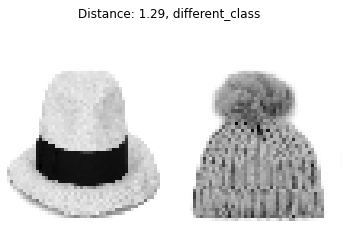

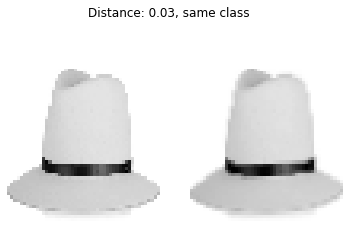

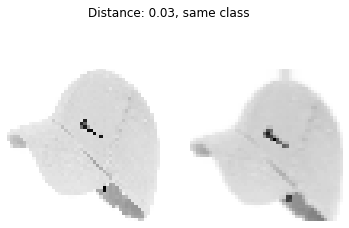

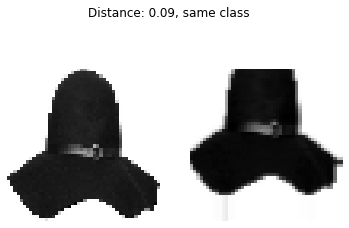

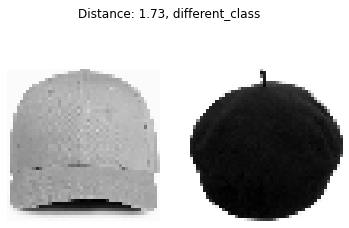

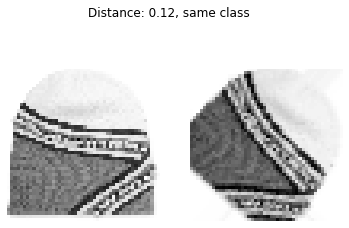

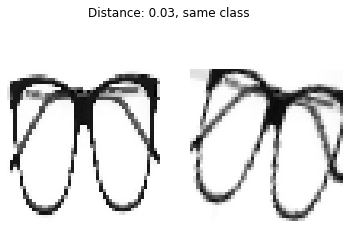

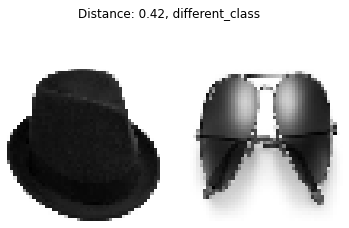

In [ ]:
# np.random.seed(42)
num_test_samples = pair_test.shape[0]
num_test_samples_check = 20
random_test_inds = np.random.choice(num_test_samples, num_test_samples_check)

for rand_ind in random_test_inds:

    img_1 = np.expand_dims(pair_test[rand_ind][0], axis=0)
    img_2 = np.expand_dims(pair_test[rand_ind][1], axis=0)
    is_same_class = label_test[rand_ind]
    preds = model.predict([img_1, img_2])
    proba = preds[0][0]
    
    fig = plt.figure(figsize=(6, 4))
    label_text = "same class" if is_same_class else "different_class"
    plt.suptitle("Distance: {:.2f}, {}".format(proba, label_text))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    orig_img_1 = img_1.reshape((48,48))
    orig_img_2 = img_2.reshape((48,48))
    plt.imshow(orig_img_1, cmap=plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(orig_img_2, cmap=plt.cm.gray)
    plt.axis("off")
    # show the plot
    plt.show()


### Embeddings Visualization

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
import time

In [ ]:
visualization_df = pd.DataFrame([])

In [ ]:
embeddings = embeding_extractor.predict(test_x)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)
visualization_df['pca-one'] = pca_result[:,0]
visualization_df['pca-two'] = pca_result[:,1]
visualization_df['categorytype'] = df_test["categorytype"]
print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')

Explained variation per principal component: [0.7171915  0.19900984]


No handles with labels found to put in legend.


Text(0, 0.5, 'pca-two')

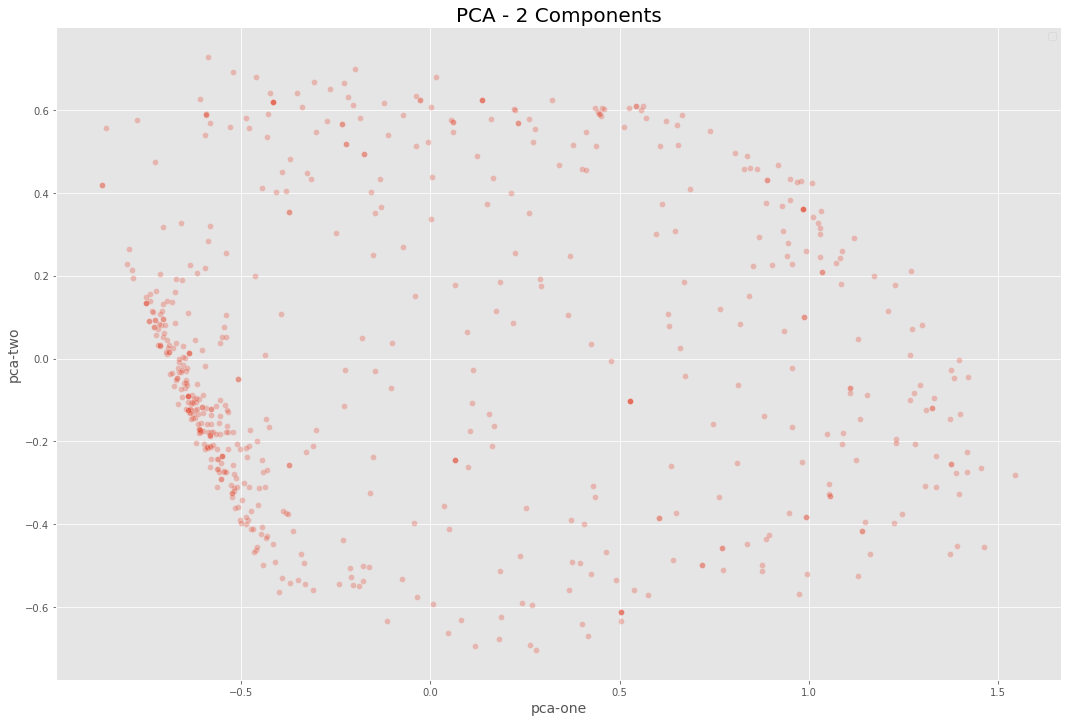

In [ ]:
plt.figure(figsize=(18,12))
sns.scatterplot(
    x="pca-one", y="pca-two",
    # hue="categorytype",
    # palette=sns.color_palette("hls", num_classes),
    data=visualization_df,
    legend="full",
    alpha=0.3,
)
plt.legend(loc='upper right')
plt.title("PCA - 2 Components", fontsize=20)
plt.xlabel("pca-one", fontsize=14)
plt.ylabel("pca-two", fontsize=14)


In [ ]:
train_embeddings = embeding_extractor.predict(train_x)
train_embeddings.shape

(1801, 48)

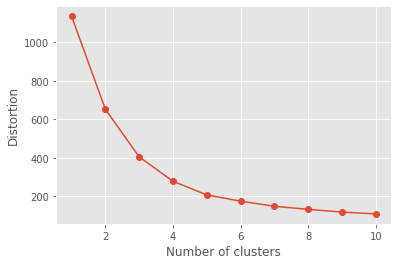

In [ ]:
from sklearn.cluster import KMeans
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(train_embeddings)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
km = KMeans(
    n_clusters=5, init='random',
    n_init=10, max_iter=500, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(train_embeddings)

In [ ]:
train_x.shape

(1801, 48, 48, 1)

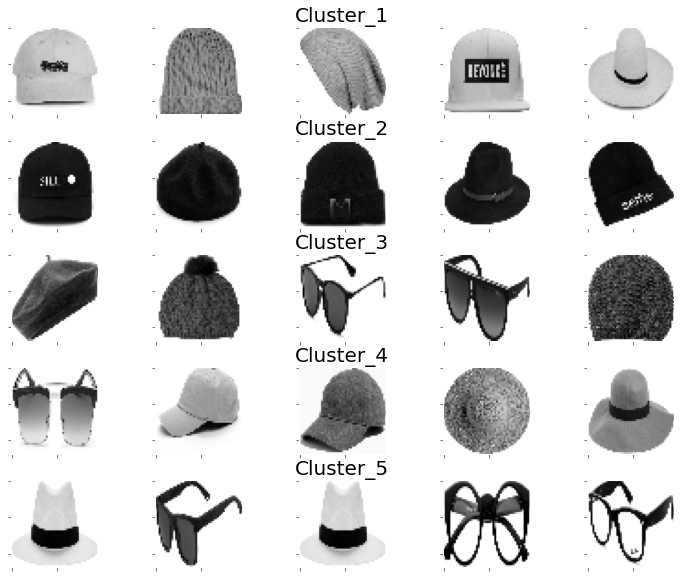

In [ ]:
unique_class_names = np.unique(y_km).tolist()
num_unique_categories = len(unique_class_names)
num_img_per_cluster = 5
fig, axs = plt.subplots(num_unique_categories, num_img_per_cluster, figsize=(25, 25))
fig.subplots_adjust(wspace=0, hspace=0.3, top=1.3, bottom=1, left=1, right=1.4)
count=0
for class_ind, class_name in enumerate(unique_class_names):
  rel_class_inds = y_km == class_name
  rel_images = train_x[rel_class_inds][:num_img_per_cluster]
  for img_ind in range(num_img_per_cluster):
    rel_image = rel_images[img_ind,:].reshape(48,48)
    axs[class_ind,img_ind].imshow(rel_image, cmap='gray')
    axs[class_ind,img_ind].set_xticklabels([])
    axs[class_ind,img_ind].set_yticklabels([])
    axs[class_ind,img_ind].set_aspect('equal')
    axs[class_ind,img_ind].grid(False)
    
    count+=1
    
    if img_ind == 2:
      axs[class_ind,img_ind].set_title(f"Cluster_{class_name+1}", fontsize=20)